In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [107]:
# relative imports

import sys
sys.path.append("../commons")

import json
import os.path
from collections import defaultdict
from commons import measurements, atlas_reader, build_dict, build_graph, build_heatmap, clusterize, sort_from_dict
from classes import Result

In [72]:
for msm in measurements:
    
    filename='data/atlas/{file}.json'.format(file=msm)
    
    if os.path.isfile(filename):
        print 'Measurement file already there'
        continue
        
    url = "https://atlas.ripe.net/api/v2/measurements/{msm}/results/?format=json".format(msm=msm)
    res = atlas_reader(url)
    f = open(filename, 'w+')
    f.write(json.dumps(res))
    f.close()

Measurement file already there
Measurement file already there
Measurement file already there
Measurement file already there
Measurement file already there
Measurement file already there
Measurement file already there


In [73]:
results = []
for msm in measurements:
    j = open('data/atlas/{msm}.json'.format(msm=msm)).read()
    for r in json.loads(j):
        results.append(Result.parse_atlas_ping_result(r))

In [74]:
from commons import update_progress

if os.path.isfile('data/atlas/probes.json'):
    print 'Probes file already there'
    f = open('data/atlas/probes.json', 'r')
    probes = json.loads(f.read())
    
else:
    print 'Fetching probes info.'
    N = len(results)
    probes = defaultdict(str)
    for i,p in enumerate([r.prb_id for r in results]):

        update_progress(100.0*i/N)

        if p in probes.keys():
            continue

        url = "https://atlas.ripe.net/api/v2/probes/{prb_id}?format=json&fields=country_code".format(prb_id=p)
        prb_info = atlas_reader(url)
        probes[p] = prb_info
    
    f = open('data/atlas/probes.json', 'w+')
    f.write(json.dumps(probes))
    f.close()

Probes file already there


In [75]:
for r in results:
    r.country_origin = probes[str(r.prb_id)]['country_code']

In [79]:
from commons import get_cc_from_ip_address

N = len(results)

for i,r in enumerate(results):
    
    update_progress(100.0*i/N)
    
    r.country_origin = probes[str(r.prb_id)]['country_code']
    r.country_destination = get_cc_from_ip_address(r.ip_destination)

Building dict 100.00%

In [114]:
dictionary = build_dict(
    results=[r for r in results if r.avg_rtt>.0],
    origin_attribute='country_origin',
    destination_attribute='country_destination',
    min_squares=3
)

Building dict 100.00%
Omitted  [u'DE', u'DZ', u'LV', u'LY', u'LB', u'CD', u'GA', u'CV', u'ML', u'SO', u'SL']


In [115]:
G = build_graph(dictionary=dictionary)

In [116]:
clusters = clusterize(G)

 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


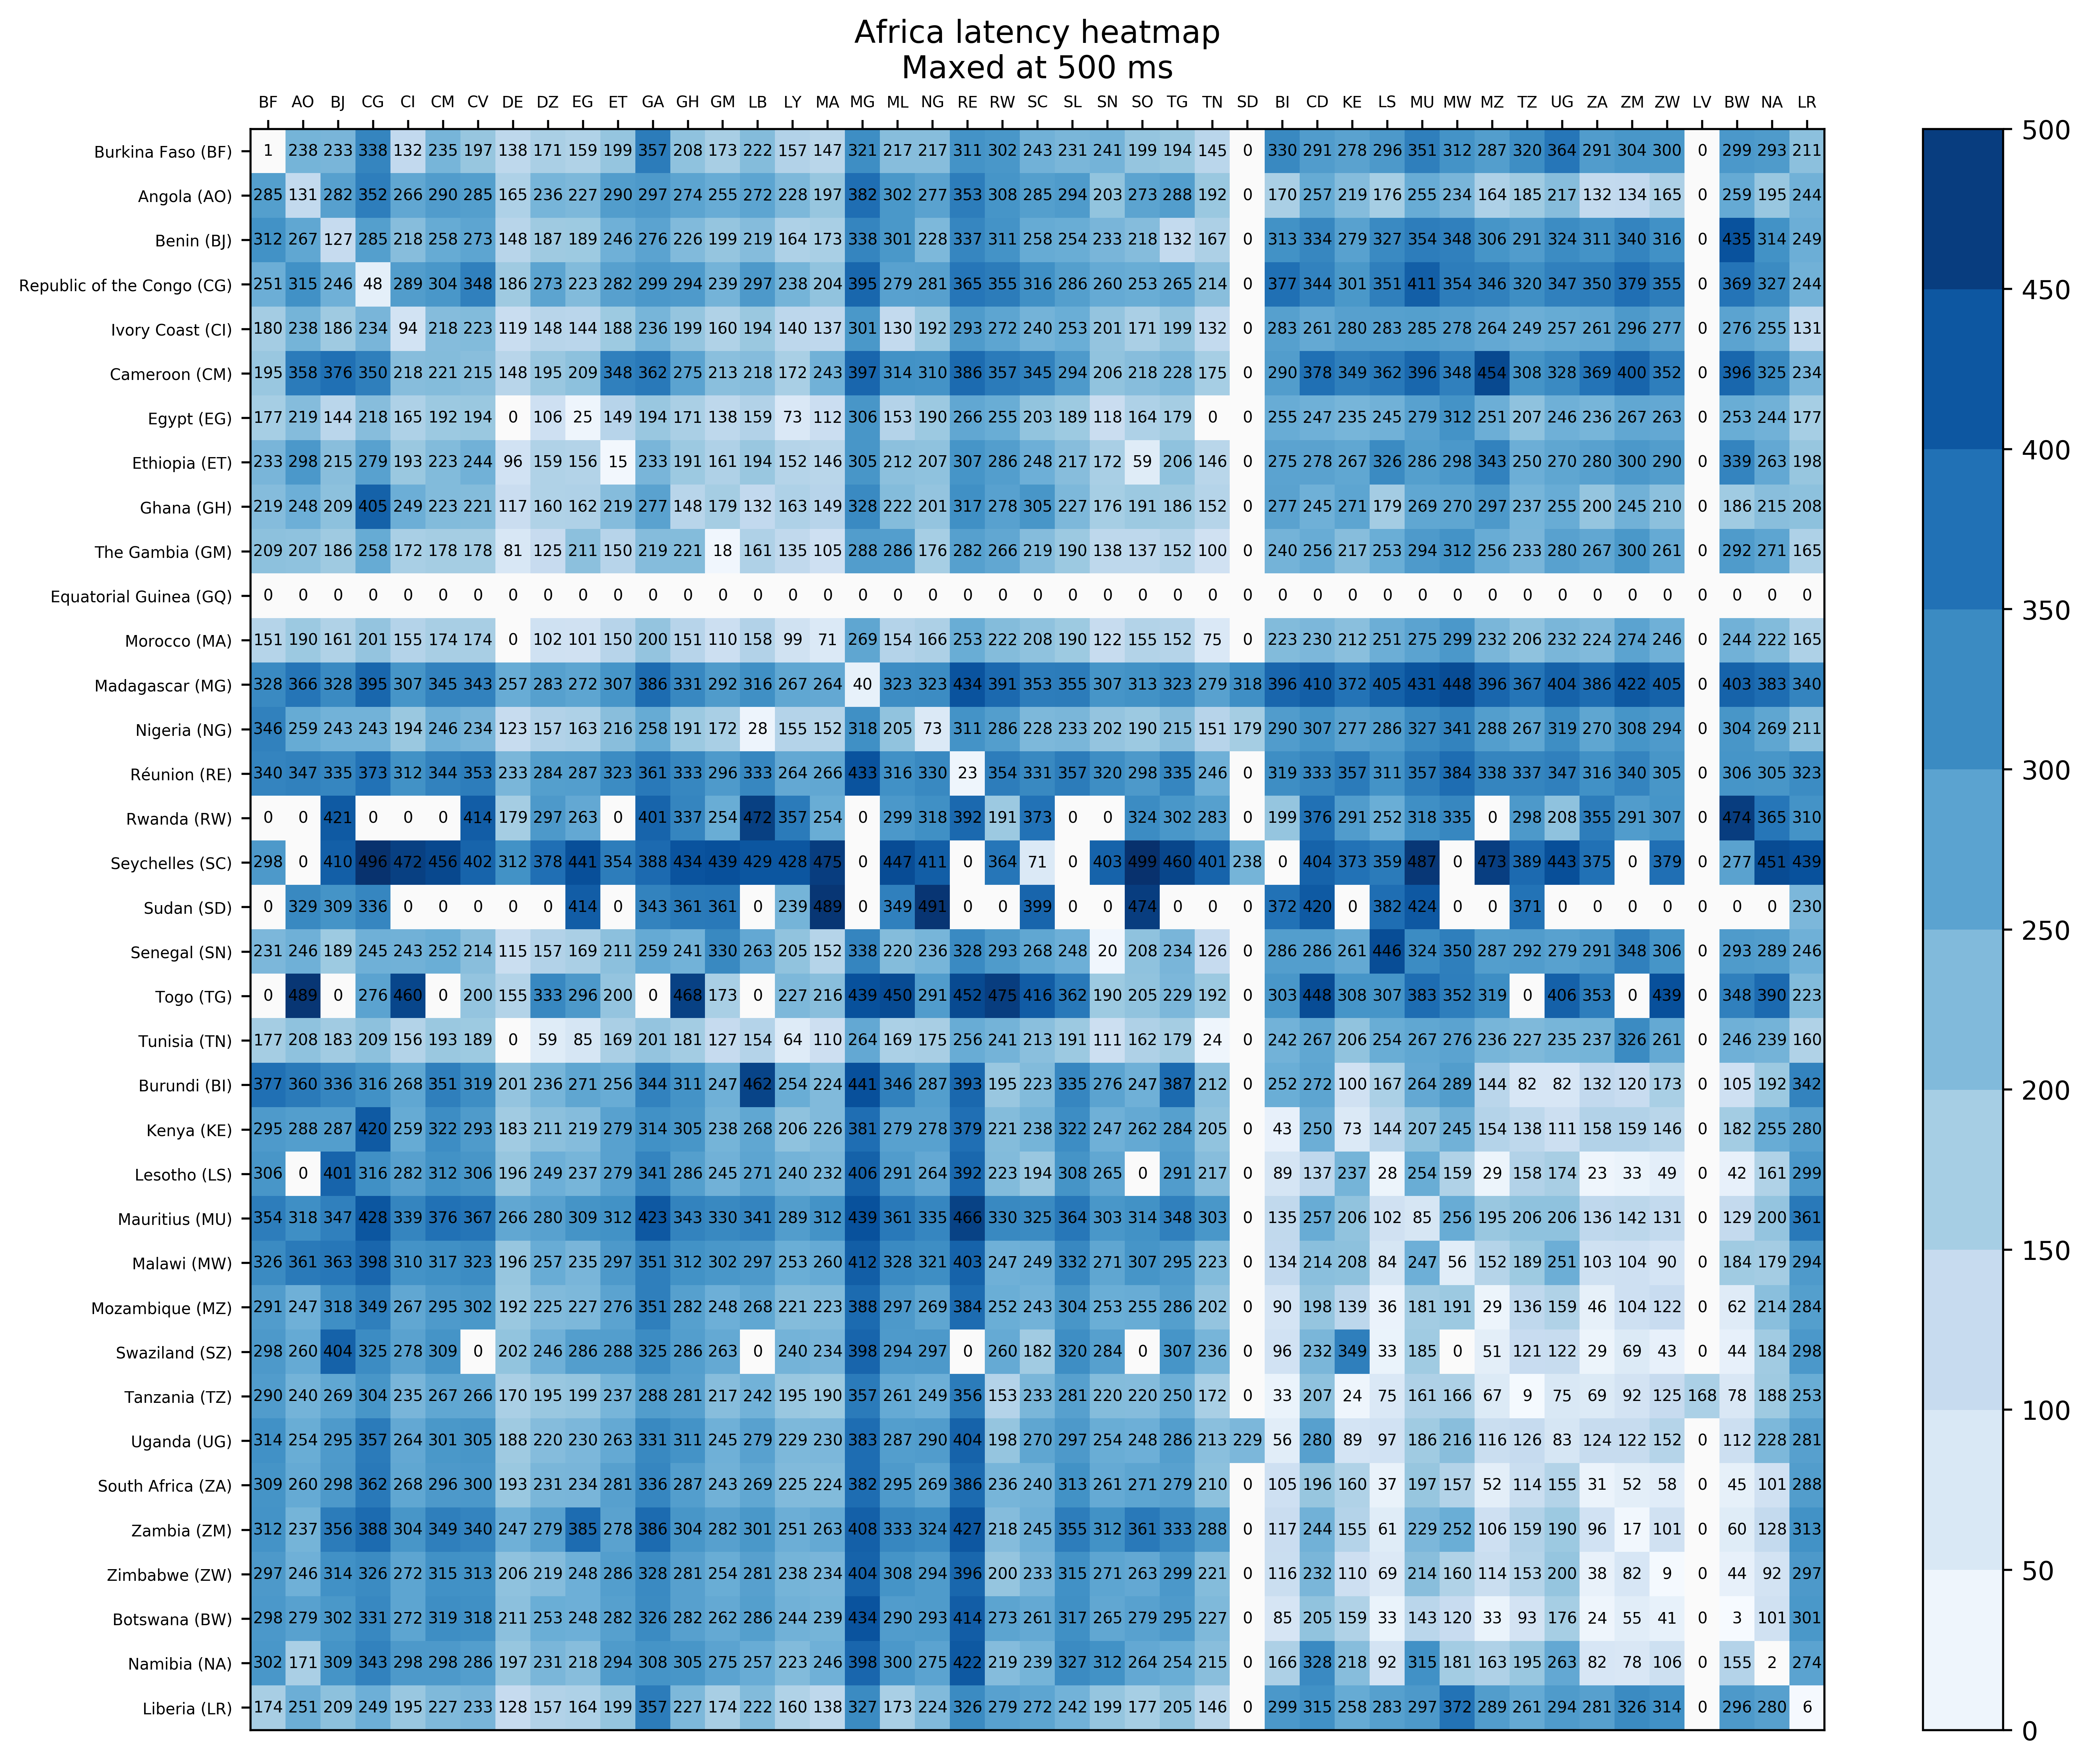

In [121]:
build_heatmap(
    dictionary,
    filename="figs/matrix-cluster-sort-atlas",
    plot_text=True,
    _max=500,
    fontsize=6,
    figsize=(12,9),
    _ticks=50,
    sort=sort_from_dict(clusters)
)